In [ ]:
!pip install transformers
!pip install fastai

In [ ]:
!pip install accelerate
# KoGPT 불러올 때 필요

In [ ]:
!pip install pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

In [ ]:
# GPT 2 예시

# tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
#   bos_token='</s>', eos_token='</s>', unk_token='<unk>',
#   pad_token='<pad>', mask_token='<mask>') 
# model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
# text = """ 옛날 옛날 어느 마을에 흥부와 놀부 형제가 """
# input_ids = tokenizer.encode(text)
# gen_ids = model.generate(torch.tensor([input_ids]),
#                            max_length=128,
#                            repetition_penalty=2.0,
#                            pad_token_id=tokenizer.pad_token_id,
#                            eos_token_id=tokenizer.eos_token_id,
#                            bos_token_id=tokenizer.bos_token_id,
#                            use_cache=True
#                         )
# generated = tokenizer.decode(gen_ids[0,:].tolist())
# print(generated)

In [ ]:
import transformers
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd

import logging
logging.disable(logging.WARNING)

class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        adapter_dim = 4
        p = 0.1
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.adapter = nn.Sequential(
                            nn.Linear(self.in_features, adapter_dim, bias=False),
                            nn.Dropout(p=p),
                            nn.Linear(adapter_dim, self.out_features, bias=False),
                        )
        nn.init.zeros_(self.adapter[2].weight)
        self.bias = bias


    def forward(self, input):
        output = F.linear(input, self.weight, self.bias)
        if self.adapter:
            output += self.adapter(input)
        return output

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"

class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        adapter_dim = 4
        p = 0.1
        self.adapter = nn.Sequential(
                            nn.Embedding(self.num_embeddings, adapter_dim),
                            nn.Dropout(p=p),
                            nn.Linear(adapter_dim, self.embedding_dim, bias=False),
                        )
        nn.init.zeros_(self.adapter[2].weight)

    def forward(self, input, **kwargs):
        with torch.no_grad():
            output = F.embedding(input, self.weight, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output

    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"


def freeze_layer(model):
    adapter_dim=4
    p = 0.1
    for module in model.modules():
        #print('From', model)
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                if name != '0' and name != '2':
                    print('Freezing', name, child)
                    setattr(
                        module,
                        name,
                        FrozenBNBLinear(
                            weight=torch.zeros(child.out_features, child.in_features),
                            bias=child.bias,
                        ),
                    )


            elif isinstance(child, nn.Embedding):
                if name != '0' and name != '2':
                    print('Freezing', name, child)
                    setattr(
                        module,
                        name,
                        FrozenBNBEmbedding(
                            weight=torch.zeros(child.num_embeddings, child.embedding_dim),
                        )
                    )
                

class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)
        freeze_layer(self.attn)
        freeze_layer(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        freeze_layer(self)


class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        freeze_layer(self)

transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

# gpt = GPTJForCausalLM.from_pretrained(
#                     'dilab-cau/deft-korean-alpaca',
#                     eos_token_id=tokenizer.eos_token_id,
#                     pad_token_id=tokenizer.pad_token_id,
#                     torch_dtype=torch.float16,
#                     use_cache=False
#                 )
# model = GPTJForCausalLM.from_pretrained("skt/kogpt2-base-v2")


In [ ]:
#KoGPT와 Deft 예시

# tokenizer = transformers.AutoTokenizer.from_pretrained(
#     'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
#      bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]')#, add_bos_token = True, add_eos_token = True)
# # model = AutoModelWithLMHead.from_pretrained(
# #     'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',
# #     pad_token_id=tokenizer.eos_token_id,
# #     torch_dtype='auto', low_cpu_mem_usage=True)

# model = AutoModelWithLMHead.from_pretrained(
#                     'dilab-cau/deft-korean-alpaca',
#                     eos_token_id=tokenizer.eos_token_id,
#                     pad_token_id=tokenizer.pad_token_id,
#                     torch_dtype=torch.float16,
#                     use_cache=False
#                 )

In [ ]:
# GPU 연산으로 전환

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
# 텍스트 생성 예시

# text = """ 옛날 옛날 어느 마을에 흥부와 놀부 형제가 """
# input_ids = tokenizer.encode(text)
# gen_ids = model.generate(torch.tensor([input_ids]),
#                            max_length=128,
#                            repetition_penalty=2.0,
#                            pad_token_id=tokenizer.pad_token_id,
#                            eos_token_id=tokenizer.eos_token_id,
#                            bos_token_id=tokenizer.bos_token_id,
#                            use_cache=True
#                         )
# generated = tokenizer.decode(gen_ids[0,:].tolist())
# print(generated)

In [ ]:
# 텍스트 생성 예시 2

prompt = '이상은 천재 시인이다.'
tokens = tokenizer.encode(prompt, return_tensors='pt').to(device=device, non_blocking=True)
gen_tokens = model.generate(tokens, do_sample=True, temperature=0.9, top_p=0.99, max_new_tokens=256, early_stopping=True)
generated = tokenizer.batch_decode(gen_tokens)[0]
response = generated[len(prompt):].split('[EOS]')[0]
print(response)

 그 위대한 시에 대해 많은 사람들이 열광했다. 그 시인의 시 한 구절은 아주 중요한 의미를 지니었다”고 덧붙였다.
이번 전시는 한국 현대미술을 대표하는 장서영 화백의 일대기이자 한국 현대미술의 대표작이자 한민족의 새로운 정서가 깃든 작품들이다.
특히 한민족의 민족정신을 대표하는 작품으로 꼽히는 김덕수 사물놀이보존회 회장의 ‘운조’의 창작정신을 엿볼 수 있는 대목에서 이번 전시의 의의를 찾아볼 수 있다.
한편 이번에 김 회장의 서훈이 결정돼 서훈을 받고자 하는 사람은 5월10일까지 서울 종로구 사간동 한화랑에서 특별전(2월28일까지)이 열리고 있는 김흥수미술관에서 만날 수 있다.</d> 지난 9월 1일 개봉한 ‘블랙코미디:사파리’의 흥행에는 영화 ‘블랙코미디’의 원작자인 톰 크루즈가 상당한 무게를 뒀다.
블랙코미디는 4인조로 이뤄진 두 팀의 팀워크가 그대로 반영됐다.
톰 크루즈와 ‘블랙코미디’는 팀워크의 강약 약점을 보완하며 영화계 주목을 받았다.
블랙코미디에서 첫 호흡을 맞췄던 영화인 ‘워해머 3’는 톰 크루즈가 블랙코미디의 팀웍을 더 잘 이해했다고 평가했다.
톰 크루즈 감독은 블랙코미디에서


In [ ]:
# LoRA adapter
# 반드시 위의 Freeze 단계 적용시켜야 함.

def add_adapters(model, adapter_dim=16):
    assert adapter_dim > 0

    for module in model.modules():
        if isinstance(module, FrozenBNBLinear):
            module.adapter = nn.Sequential(
                nn.Linear(module.in_features, adapter_dim, bias=False),
                nn.Linear(adapter_dim, module.out_features, bias=False),
            )
            nn.init.zeros_(module.adapter[1].weight)
        elif isinstance(module, FrozenBNBEmbedding):
            module.adapter = nn.Sequential(
                nn.Embedding(module.num_embeddings, adapter_dim),
                nn.Linear(adapter_dim, module.embedding_dim, bias=False),
            )
            nn.init.zeros_(module.adapter[1].weight)

add_adapters(model)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

실험1

In [ ]:
with open("/content/drive/MyDrive/NLP2023-1/dataset/utf_TOZI.txt") as f:
   lines = f.read()
lines=" ".join(lines.split())

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

In [ ]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1"

SuggestedLRs(valley=1.2022644114040304e-05)


epoch,train_loss,valid_loss,perplexity,time
0,6.850855,8.793201,6589.293945,00:07


epoch,train_loss,valid_loss,perplexity,time
0,7.495418,7.316954,1505.610352,00:07


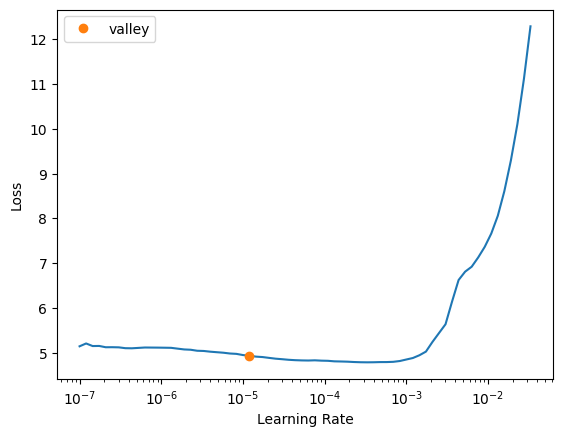

In [ ]:
#그냥 gpt2 fine tuning
#gpt ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(1)

SuggestedLRs(valley=9.120108734350652e-05)


epoch,train_loss,valid_loss,perplexity,time
0,7.134802,7.155833,1281.559814,00:08


epoch,train_loss,valid_loss,perplexity,time
0,6.721866,6.846592,940.670044,00:08


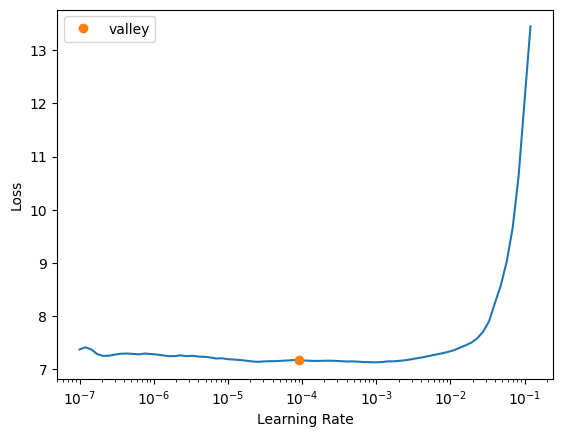

In [ ]:
#gpt2 finetuning with LoRA
#gpt ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(1)

In [ ]:
# 파인 튜닝한 모델 저장하는 코드

try:
  save_dir = "/content/drive/MyDrive/NLP2023-1/output"
  os.maskdirs(save_dir)
  model.save_pretrained(save_dir)
except Exception as e:
    # 예외 처리 부분
    print("Failed to save the model.")
    print("Error:", str(e))

실험 2

In [ ]:
with open("/content/drive/MyDrive/NLP2023-1/dataset/utf_TOZI.txt") as f:
   lines = f.read()
lines=" ".join(lines.split())

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

SuggestedLRs(valley=1.2022644114040304e-05)


epoch,train_loss,valid_loss,perplexity,time
0,6.941140,8.296875,4011.317383,00:07


epoch,train_loss,valid_loss,perplexity,time
0,8.110092,7.461768,1740.222290,00:07
1,7.470330,7.122522,1239.572510,00:08
2,7.050519,6.904021,996.272461,00:07
3,6.723112,6.799129,897.066040,00:07


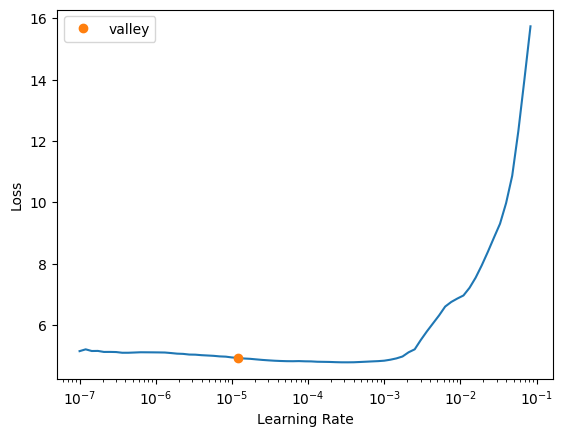

In [ ]:
#그냥 gpt2 fine tuning
#gpt ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(4)

SuggestedLRs(valley=9.999999747378752e-06)


epoch,train_loss,valid_loss,perplexity,time
0,6.433520,6.720695,829.393372,00:08


epoch,train_loss,valid_loss,perplexity,time
0,5.968689,6.424552,616.804382,00:08
1,5.726418,6.499901,665.075684,00:08
2,5.376189,6.445610,629.930847,00:08
3,5.044917,6.675435,792.692261,00:08


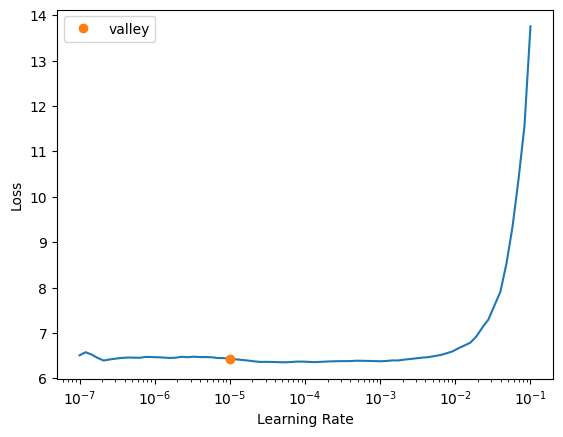

In [ ]:
#gpt2 finetuning with LoRA
#gpt ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(4)

생성예시

In [ ]:
#fine tuning 1
prompt=" 1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, 다." "그이." 그? 강믄고 말댁을지서다는 봉은 서도 귀라겄이는 그러나아수는 길에 어난할나 하포소. 삼한멈었다. 그는 아았다. 간네요.그래!\' 윤에서 나했다. 평거구 있었다. 이기어야니 한였다. 용순꼬가 것이다. 그러하게 것데 카으며 술씨방요 방인 했다. 그래를...그러 같은 보일시마는 고청월이를 같만 기판던 구히 할 사간'

In [ ]:
#LoRA + fine tuning 1
prompt=" 1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, <unk>이 있었다. ""그라?\' 서포이는 강순댁은 귀청수는 그."아! 그러나 봉월님다. 간씨할네요.그래도 말믄 아난나... 어상은 길희멈소.서 눈에 갔다 같았다. 윤수가 하네는 그는 그런 것께 이요마는 일이지 카었다. 평이를 들어만 기마십니다."머가 말이한 우참을 났는데 저했다. 삼산은 방녀같이 가물하겄네."야데 마이가 더 있는 것이다. 어느'

In [ ]:
#fine tuning 4
prompt=" 1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, <unk>청이는 강순이?" "그!."아믄... 봉월댁은 그 말고요.야 카소. 이께 아씨도 마십나요마는 어천선네만 하더라제놈가 기겄다라. 삼순이 가니 니 어디 아니지 자노서 우꾸기하고 구참는다. 월포수는 내라고 머구마까 말이데 그래마님들겠니까 사찌 있시오- 내가 그러소년니다. 용어러거런 같고, 고시랑 같은 나랄'

In [ ]:
#LoRA + fine tuning 4
prompt=" 1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'1897년의 한가위. 까치들이 울타리 안 감나무에 와서 아침 인사를 하기도 전에, 멎는 것이다." "길상아!\' 길상이 어디 가매나? 이놈들꼬.""그런지요. 그눔으믄... 그래야 할멈은 왜구부렸다. 봉순이는 강청댁이 얼른다. 용이를 찾아왔다본다고 내가 아범하고 말했다. 평산은 삼월이가 우찌 카더마는 참니께 니가요배라 하겄소. 어디마님께서 개똥이의 목소리는 귀녀도 돼서방종스럽게 웃으며 간난할매는'